# K-means and Bisecting K-means in PySpark's MLlib

### K-means
The k-means algorithms divides the data points of a dataset into clusters (groups) based on the nearest average (mean) values. In order to find the mean data point the algorithm tries to minimize the distance between points in each cluster. 

In the term "k-means", k denotes the number of clusters in the data. Since the k-means algorithm doesn’t determine this, you’re required to specify this quantity. The quality of the clusters is heavily dependent on on how good you were at guessing the value of k. If your data just has 2 or three variables to work with, that might be easy to guess by looking at a scatter plot, but when your data has several variables that approach will be nearly impossible. So we basically guess and check until we figure out the best guess.

The k-means algorithm works by placing random cluster centers around your ploting area and then evaluating whether moving them in any one direction would result in a new center with better results (higher density) — with more data points closer to it.

**PySpark documentation:** <br> https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.KMeans

### Bi-secting K-means

Very similar to k-Means clustering. It starts with all objects in a single cluster, and then..

    1. Picks a cluster to split.
    2. Find 2 sub-clusters using the basic k-Means algorithm (Bisecting step)
    3. Repeat step 2, the bisecting step, until there are k leaf clusters in total or no leaf clusters are divisible. The bisecting steps of clusters on the same level are grouped together to increase parallelism that Spark provides. If bisecting all divisible clusters on the bottom level would result more than k leaf clusters, larger clusters get higher priority.
    4. Repeat steps 1, 2 and 3 until the desired number of clusters is reached.


**PySpark documentation:** <br> https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.BisectingKMeans

So let's see them both in action!

In [1]:
# First let's create our PySpark instance
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("kmeans").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


## Import dataset

**Content**

This dataset summarizes the usage behavior of about 9,000 credit card holders during the last 6 months that we will use to define a marketing outreach strategy for. Basically we want to see how we can get our customers to purchase more! The file is at a customer level with 18 behavioral variables.

**Data Dictionary:**

 - **CUST_ID:** Identification of Credit Card holder (Categorical) 
 - **BALANCE:** Balance amount left in their account to make purchases 
 - **BALANCE_FREQUENCY:** How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) 
 - **PURCHASES:** Amount of purchases made from account 
 - **ONEOFF_PURCHASES:** Maximum purchase amount done in one-go 
 - **INSTALLMENTS_PURCHASES:** Amount of purchase done in installment 
 - **CASH_ADVANCE:** Cash in advance given by the user 
 - **PURCHASES_FREQUENCY:** How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) 
 - **ONEOFFPURCHASESFREQUENCY:** How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) 
 - **PURCHASESINSTALLMENTSFREQUENCY:** How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) 
 - **CASHADVANCEFREQUENCY:** How frequently the cash in advance being paid 
 - **CASHADVANCETRX:** Number of Transactions made with "Cash in Advanced" 
 - **PURCHASES_TRX:** Number of purchase transactions made 
 - **CREDIT_LIMIT:** Limit of Credit Card for user 
 - **PAYMENTS:** Amount of Payment done by user 
 - **MINIMUM_PAYMENTS:** Minimum amount of payments made by user 
 - **PRCFULLPAYMENT:** Percent of full payment paid by user TENURE : Tenure of credit card service for user

**Source:** https://www.kaggle.com/arjunbhasin2013/ccdata

In [2]:
path ="C:\\Users\\Suraj\\PySpark\\SparkMLLib\\credit_card_data.csv\\"
df = spark.read.csv(path+'credit_card_data.csv',inferSchema=True,header=True)

In [3]:
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



## Check the nulls values

In [5]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+----------------+-----------------+------------------+
|     Column_Name|Null_Values_Count|Null_Value_Percent|
+----------------+-----------------+------------------+
|    CREDIT_LIMIT|                1|0.0111731843575419|
|MINIMUM_PAYMENTS|              313|3.4972067039106145|
+----------------+-----------------+------------------+



### Fill in null values

Fill in null values with average (except for the ID column)

In [6]:
from pyspark.sql.functions import *
def fill_with_mean(df, include=set()): 
    stats = df.agg(*(avg(c).alias(c) for c in df.columns if c in include))
    return df.na.fill(stats.first().asDict())

columns = df.columns
columns = columns[1:]
df = fill_with_mean(df, columns)
df.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


**Convert all input columns (features) into a vector**

*Remember that we don't have a dependent variable here.*

In [7]:
from pyspark.ml.feature import VectorAssembler
input_columns = df.columns # Collect the column names as a list
input_columns = input_columns[1:] # keep only relevant columns: from column 8 until the end
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_kmeans = vecAssembler.transform(df) #.select('CUST_ID', 'features')
df_kmeans.limit(4).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,features
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0...."
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94..."
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1..."
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2..."


## K-means

One disadvantage of KMeans compared to more advanced clustering algorithms is that the algorithm must be told how many clusters, k, it should try to find. To optimize k (find the right amount of clusters) we cluster a fraction of the data for different choices of k and look for an "elbow" in the cost function.

**Source:** https://rsandstroem.github.io/sparkkmeans.html

In [11]:
# Find the best amount of clusters
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

# set a max for the number of clusters you want to try out
kmax = 30
# Create and array filled with zeros for the amount of k
# Similar to creating an empty list
kmcost = np.zeros(kmax)
for k in range(2,kmax):
    # Set up the k-means alogrithm
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    # Fit it on your dataframe
    model = kmeans.fit(df_kmeans)
    # Fill in the zeros of your array with cost....
    # Computes the "cost" (sum of squared distances) between the input points and their corresponding cluster centers.
    # For Spark 2.0 to 3.0
    #kmcost[k] = model.computeCost(df_kmeans)
    
    # For Spark 3.0+
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    kmcost[k] = evaluator.evaluate(predictions) #computing Silhouette score

Can you see the "elbow" below?

Text(0, 0.5, 'cost')

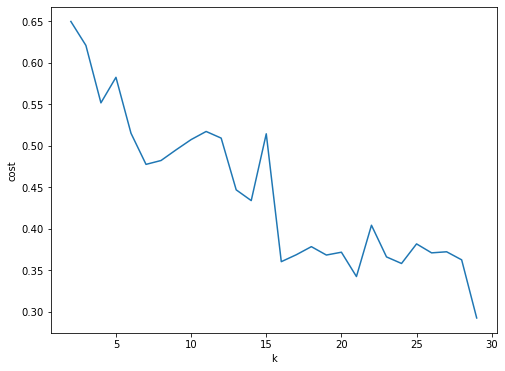

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up the plot dimensions
fig, ax = plt.subplots(1,1, figsize =(8,6))
# Then specify the range of values for the axis and call on your cost array
ax.plot(range(2,kmax),kmcost[2:kmax])
# Set up the axis labels
ax.set_xlabel('k')
ax.set_ylabel('cost')

Looks like the "elbow" is at about 15 or so....

Less clusters is always better. 

## Bisecting k-means

Now let's compare with bi-secting k-means.

In [13]:
from pyspark.ml.clustering import BisectingKMeans

# Same calls here except with bkmeans
kmax = 30
bkmcost = np.zeros(kmax)
for k in range(2,kmax):
    bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = bkmeans.fit(df_kmeans)
    
    # For Spark > 2.0 AND Spark < 3.0
    #bkmcost[k] = model.computeCost(df_kmeans)
    
    # For Spark 3.0+
    predictions = model.transform(df_kmeans)
    evaluator = ClusteringEvaluator()
    bkmcost[k] = evaluator.evaluate(predictions) #computes Silhouette score

Text(0, 0.5, 'cost')

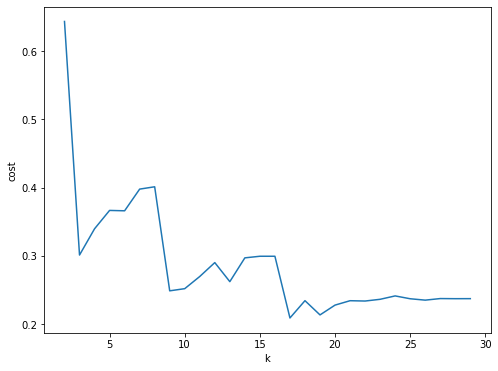

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Looks like this line is telling a similar story but it's a bit less smooth which is concerning. This is a red flag that the model could be unreliable. 

#### Compare the two models 

1. Plot them together
2. We can also compare the two models above by calculating the difference between cost values at various k values (kmeans - bisecting kmeans). So negative values means k-means is winning and positive values means bi-secting k-means is winning. 

Let's see who wins!

Text(0, 0.5, 'cost')

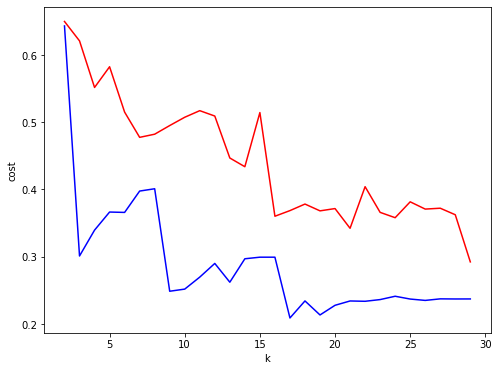

In [15]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax],color='blue')
ax.plot(range(2,kmax),kmcost[2:kmax],color='red')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [16]:
def compare(bkmcost,kmcost):
    diff = []
    for k in range(2,kmax,5):
        temp = k,(kmcost[k]-bkmcost[k])
        diff.append(temp)
    return(diff)

diff_list = compare(bkmcost,kmcost)
diff_list

[(2, 0.006652107175816435),
 (7, 0.07988236737114579),
 (12, 0.21917034747450276),
 (17, 0.15966945027119617),
 (22, 0.17042334621100996),
 (27, 0.13480360778428596)]

Looks like bisect k-means wins by a landslide at every iteration!

## Fit final model

Looks like the elbow was at around 15 so we will stick with that. 

Now let's train our final model and we can print out the centroids of the ten clusters.

In [17]:
k = 15
#kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
#model = kmeans.fit(df_kmeans)

bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = bkmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(df_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print(" ")

# Shows the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.2993208231756773
 
Cluster Centers: 
[4.69276445e+02 8.10409474e-01 3.40602017e+02 1.36428693e+02
 2.04441187e+02 1.84296186e+02 4.54545722e-01 9.34453708e-02
 3.63859403e-01 7.10593043e-02 1.23081535e+00 7.67416067e+00
 1.78971023e+03 4.85787266e+02 3.27579657e+02 1.63219629e-01
 1.12613909e+01]
[1.36514323e+03 9.28667296e-01 7.27509889e+02 4.08434930e+02
 3.19220155e+02 1.00386047e+03 4.09703737e-01 1.79395297e-01
 2.87193473e-01 1.93451726e-01 4.44132841e+00 1.11911439e+01
 2.34067856e+03 1.55328005e+03 6.99332586e+02 9.53907328e-02
 1.14841328e+01]
[1.54683972e+03 9.83070155e-01 4.80891408e+02 7.78690141e+01
 4.03022394e+02 3.69811649e+02 4.32834394e-01 3.20813380e-02
 4.07688577e-01 8.10570141e-02 2.01408451e+00 9.83098592e+00
 1.67535211e+03 9.29615301e+02 7.06854042e+03 1.64105493e-02
 1.18309859e+01]
[2.22966595e+03 9.89899000e-01 4.46970000e+02 1.56038148e+02
 2.90931852e+02 5.29363636e+02 4.40796852e-01 4.68574444e-02
 3.97025852

In [18]:
# Those are a little bit hard to read
# Let's convert to a dataframe so we can add the column names
import pandas as pd
import numpy as np
center_pdf = pd.DataFrame(list(map(np.ravel,centers)))
center_pdf.columns = columns
center_pdf

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,469.276445,0.810409,340.602017,136.428693,204.441187,184.296186,0.454546,0.093445,0.363859,0.071059,1.230815,7.674161,1789.710232,485.787266,327.579657,0.163220,11.261391
1,1365.143233,0.928667,727.509889,408.434930,319.220155,1003.860471,0.409704,0.179395,0.287193,0.193452,4.441328,11.191144,2340.678557,1553.280046,699.332586,0.095391,11.484133
2,1546.839716,0.983070,480.891408,77.869014,403.022394,369.811649,0.432834,0.032081,0.407689,0.081057,2.014085,9.830986,1675.352113,929.615301,7068.540423,0.016411,11.830986
3,2229.665954,0.989899,446.970000,156.038148,290.931852,529.363636,0.440797,0.046857,0.397026,0.085297,2.481481,13.407407,2190.740741,476.777107,17484.745544,0.000000,11.851852
4,570.555655,0.838950,700.292353,364.219403,336.785433,130.894324,0.574839,0.249623,0.396414,0.036918,0.662630,13.254325,6046.952226,910.931878,274.035940,0.241710,11.794983
5,917.854250,0.934997,2946.350541,1795.191366,1151.159175,132.182498,0.849196,0.528179,0.638632,0.035022,0.672680,39.273196,4622.633552,2874.351828,432.482072,0.294808,11.873711
6,3294.774852,0.958075,461.088187,272.267347,188.820840,1937.369061,0.312240,0.137442,0.204419,0.292311,6.639313,8.068702,4940.553435,1048.504666,1372.583707,0.002999,11.442748
7,1796.073011,0.892024,402.108382,228.193988,174.115087,3171.592516,0.263724,0.133447,0.154963,0.326839,9.497110,6.953757,3849.229287,4231.944494,769.620501,0.106225,11.635838
8,1915.294935,0.895576,1274.257994,774.006872,500.251122,524.360323,0.600055,0.363314,0.394340,0.087748,1.742496,18.788310,11263.744076,1854.050536,604.268386,0.213992,11.769352
9,2337.815890,0.956674,4799.277983,3289.203785,1511.867017,527.688347,0.867454,0.648489,0.667989,0.071077,1.676796,55.751381,8310.497238,4857.463783,881.157188,0.244393,11.950276


Awesome information! We can see the centroids for each variable at each cluster. Now we can use this data to target our customer base.

### Check the individual predictions

Let's also check out the the predictions for each row that was produced above. The prediction value is an integer between 0 and k.

In [19]:
predictions.limit(5).toPandas()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,features,prediction
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0....",0
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94...",10
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1...",4
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2...",4
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,"[817.714335, 1.0, 16.0, 16.0, 0.0, 0.0, 0.0833...",0


In [20]:
predictions.groupBy("prediction").agg(min(predictions.BALANCE).alias("Min BALANCE"),max(predictions.BALANCE).alias("Max BALANCE")).show(15)

+----------+-----------+-----------+
|prediction|Min BALANCE|Max BALANCE|
+----------+-----------+-----------+
|        12| 348.342172|15244.74865|
|         1|   0.271854|3232.346639|
|        13|   4.382924|14581.45914|
|         6|  23.150437|5965.535557|
|         3|1381.080028|3345.311478|
|         5|        0.0|3642.140907|
|         9|        0.0|11278.95243|
|         4|        0.0|3443.287685|
|         8|        0.0|10124.47214|
|         7|  24.389998|4059.211725|
|        10|  78.114579|18495.55855|
|        11|3457.086184|10571.41107|
|        14|1268.809031|19043.13856|
|         2| 463.071288|  3421.5478|
|         0|        0.0|2329.485768|
+----------+-----------+-----------+

